In [1]:
!pip install -q kaggle timm h5py torchmetrics tqdm seaborn matplotlib scikit-learn torchinfo

import os
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)

from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 27.5 MB/s eta 0:00:00
Using device: cuda


In [2]:
KAGGLE_USERNAME = "YOUR_USERNAME"
KAGGLE_KEY = "YOUR_KEY"

os.makedirs("/root/.config/kaggle", exist_ok=True)
with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)


In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi

DATA_DIR = "brain_tumor_44c"
DATASET = "fernando2rad/brain-tumor-mri-images-44c"

if not os.path.exists(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET, path=DATA_DIR, unzip=True)

print("Dataset downloaded to:", DATA_DIR)


Dataset URL: https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c
Dataset downloaded to: brain_tumor_44c


In [4]:
from pathlib import Path

IMAGE_EXTS = (".jpg", ".jpeg", ".png")

paths, labels = [], []

# Collect class folders
class_dirs = []
for root, dirs, files in os.walk(DATA_DIR):
    if any(f.lower().endswith(IMAGE_EXTS) for f in files):
        class_dirs.append(root)

class_dirs = sorted(class_dirs)

class_to_idx = {Path(d).name: idx for idx, d in enumerate(class_dirs)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Number of classes:", len(class_to_idx))

for root, _, files in os.walk(DATA_DIR):
    class_name = Path(root).name
    if class_name not in class_to_idx:
        continue

    label = class_to_idx[class_name]

    for f in files:
        if f.lower().endswith(IMAGE_EXTS):
            paths.append(os.path.join(root, f))
            labels.append(label)

df = pd.DataFrame({
    "image_path": paths,
    "label": labels
})

print("Total images:", len(df))
print("Class distribution:\n", df["label"].value_counts().sort_index())

num_classes = df["label"].nunique()


Number of classes: 44
Total images: 4478
Class distribution:
 label
0     176
1     232
2     171
3      66
4     112
5      73
6      45
7      48
8      57
9      20
10     18
11     23
12     27
13     40
14     33
15     55
16     94
17     55
18     30
19     31
20     17
21     23
22     67
23     41
24    272
25    369
26    233
27    130
28    223
29    104
30     86
31     72
32     66
33     66
34    108
35     63
36    148
37    194
38    123
39     28
40     84
41     33
42    251
43    271
Name: count, dtype: int64


In [5]:
train_df, test_df = train_test_split(
    df, stratify=df.label, test_size=0.2, random_state=42
)

train_df, val_df = train_test_split(
    train_df, stratify=train_df.label, test_size=0.2, random_state=42
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


Train: 2865
Val: 717
Test: 896


In [6]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, label


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 224 is fine for base
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])


In [8]:
train_loader = DataLoader(
    BrainTumorDataset(train_df, transform),
    batch_size=16,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    BrainTumorDataset(val_df, transform),
    batch_size=16,
    num_workers=2
)

test_loader = DataLoader(
    BrainTumorDataset(test_df, transform),
    batch_size=16,
    num_workers=2
)


In [9]:
import timm
model = timm.create_model(
    "mobilenetv2_100",
    pretrained=True,
    num_classes=num_classes
)

model = model.to(device)

print("MobileNetV2 model loaded successfully")

summary(model, input_size=(1,3,224,224))



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

MobileNetV2 model loaded successfully


Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  [1, 44]                   --
├─Conv2d: 1-1                                 [1, 32, 112, 112]         864
├─BatchNormAct2d: 1-2                         [1, 32, 112, 112]         64
│    └─Identity: 2-1                          [1, 32, 112, 112]         --
│    └─ReLU6: 2-2                             [1, 32, 112, 112]         --
├─Sequential: 1-3                             [1, 320, 7, 7]            --
│    └─Sequential: 2-3                        [1, 16, 112, 112]         --
│    │    └─DepthwiseSeparableConv: 3-1       [1, 16, 112, 112]         896
│    └─Sequential: 2-4                        [1, 24, 56, 56]           --
│    │    └─InvertedResidual: 3-2             [1, 24, 56, 56]           5,136
│    │    └─InvertedResidual: 3-3             [1, 24, 56, 56]           8,832
│    └─Sequential: 2-5                        [1, 32, 28, 28]           --
│    │    └─

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4
)

EPOCHS = 30
patience = 5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS
)


In [11]:
def get_metrics():
    return {
        "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
        "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
        "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
        "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
        "auc": MulticlassAUROC(num_classes=num_classes).to(device),
        "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
    }

def multiclass_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    spec, sens = [], []

    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp+fp+fn)

        spec.append(tn/(tn+fp+1e-8))
        sens.append(tp/(tp+fn+1e-8))

    return float(np.mean(spec)), float(np.mean(sens))


In [12]:
from PIL import Image


In [13]:
history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "precision": [], "val_precision": [],
    "recall": [], "val_recall": [],
    "f1": [], "val_f1": [],
    "specificity": [], "val_specificity": [],
    "sensitivity": [], "val_sensitivity": [],
    "mcc": [], "val_mcc": [],
    "auc": [], "val_auc": []
}

best_val_loss = float("inf")
counter = 0

for epoch in range(EPOCHS):

    # ================= TRAIN =================
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []
    train_metrics = get_metrics()

    pbar = tqdm(train_loader, desc=f"Training - Epoch [{epoch+1}/{EPOCHS}]")

    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = out.argmax(1)

        train_preds.append(preds.cpu())
        train_targets.append(y.cpu())

        for m in train_metrics.values():
            m.update(out, y)

    train_loss /= len(train_loader)

    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()

    train_spec, train_sens = multiclass_specificity_sensitivity(train_targets, train_preds)
    train_out = {k: v.compute().item() for k, v in train_metrics.items()}

    print(f"\n===== Epoch {epoch+1} TRAIN =====")
    print(f"Loss: {train_loss:.4f}")
    print(f"Acc: {train_out['acc']:.4f} | Prec: {train_out['precision']:.4f} | "
          f"Recall: {train_out['recall']:.4f} | F1: {train_out['f1']:.4f}")
    print(f"Spec: {train_spec:.4f} | Sens: {train_sens:.4f} | "
          f"MCC: {train_out['mcc']:.4f} | AUC: {train_out['auc']:.4f}")

    # ================= VALID =================
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    val_metrics = get_metrics()

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Validating"):
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()

            preds = out.argmax(1)
            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

            for m in val_metrics.values():
                m.update(out, y)

    val_loss /= len(val_loader)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_spec, val_sens = multiclass_specificity_sensitivity(val_targets, val_preds)
    val_out = {k: v.compute().item() for k, v in val_metrics.items()}

    print(f"\n===== Epoch {epoch+1} VALID =====")
    print(f"Loss: {val_loss:.4f}")
    print(f"Acc: {val_out['acc']:.4f} | Prec: {val_out['precision']:.4f} | "
          f"Recall: {val_out['recall']:.4f} | F1: {val_out['f1']:.4f}")
    print(f"Spec: {val_spec:.4f} | Sens: {val_sens:.4f} | "
          f"MCC: {val_out['mcc']:.4f} | AUC: {val_out['auc']:.4f}")

    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6e}\n")

    scheduler.step()

    # ================= SAVE HISTORY =================
    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["accuracy"].append(train_out["acc"])
    history["val_accuracy"].append(val_out["acc"])
    history["precision"].append(train_out["precision"])
    history["val_precision"].append(val_out["precision"])
    history["recall"].append(train_out["recall"])
    history["val_recall"].append(val_out["recall"])
    history["f1"].append(train_out["f1"])
    history["val_f1"].append(val_out["f1"])
    history["specificity"].append(train_spec)
    history["val_specificity"].append(val_spec)
    history["sensitivity"].append(train_sens)
    history["val_sensitivity"].append(val_sens)
    history["mcc"].append(train_out["mcc"])
    history["val_mcc"].append(val_out["mcc"])
    history["auc"].append(train_out["auc"])
    history["val_auc"].append(val_out["auc"])

    # ================= EARLY STOPPING =================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_mobilenetv2_44c.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Training - Epoch [1/30]: 100%|██████████| 180/180 [00:30<00:00,  6.00it/s]



===== Epoch 1 TRAIN =====
Loss: 1.6398
Acc: 0.4178 | Prec: 0.5196 | Recall: 0.4178 | F1: 0.4382
Spec: 0.9898 | Sens: 0.4178 | MCC: 0.5520 | AUC: 0.9254


Validating: 100%|██████████| 45/45 [00:03<00:00, 12.36it/s]



===== Epoch 1 VALID =====
Loss: 0.8078
Acc: 0.6803 | Prec: 0.7634 | Recall: 0.6803 | F1: 0.6878
Spec: 0.9947 | Sens: 0.6803 | MCC: 0.7689 | AUC: 0.9893
Current LR: 5.000000e-04



Training - Epoch [2/30]: 100%|██████████| 180/180 [00:17<00:00, 10.31it/s]



===== Epoch 2 TRAIN =====
Loss: 0.4893
Acc: 0.8188 | Prec: 0.8670 | Recall: 0.8188 | F1: 0.8390
Spec: 0.9969 | Sens: 0.8188 | MCC: 0.8645 | AUC: 0.9963


Validating: 100%|██████████| 45/45 [00:04<00:00,  9.58it/s]



===== Epoch 2 VALID =====
Loss: 0.5405
Acc: 0.7748 | Prec: 0.8317 | Recall: 0.7748 | F1: 0.7834
Spec: 0.9961 | Sens: 0.7748 | MCC: 0.8280 | AUC: 0.9952
Current LR: 4.986305e-04



Training - Epoch [3/30]: 100%|██████████| 180/180 [00:17<00:00, 10.01it/s]



===== Epoch 3 TRAIN =====
Loss: 0.1937
Acc: 0.9443 | Prec: 0.9588 | Recall: 0.9443 | F1: 0.9508
Spec: 0.9990 | Sens: 0.9443 | MCC: 0.9572 | AUC: 0.9996


Validating: 100%|██████████| 45/45 [00:03<00:00, 11.61it/s]



===== Epoch 3 VALID =====
Loss: 0.5172
Acc: 0.8410 | Prec: 0.8752 | Recall: 0.8410 | F1: 0.8433
Spec: 0.9966 | Sens: 0.8410 | MCC: 0.8529 | AUC: 0.9956
Current LR: 4.945369e-04



Training - Epoch [4/30]: 100%|██████████| 180/180 [00:18<00:00,  9.59it/s]



===== Epoch 4 TRAIN =====
Loss: 0.1119
Acc: 0.9741 | Prec: 0.9857 | Recall: 0.9741 | F1: 0.9796
Spec: 0.9995 | Sens: 0.9741 | MCC: 0.9793 | AUC: 0.9999


Validating: 100%|██████████| 45/45 [00:03<00:00, 12.25it/s]



===== Epoch 4 VALID =====
Loss: 0.4074
Acc: 0.8439 | Prec: 0.9008 | Recall: 0.8439 | F1: 0.8529
Spec: 0.9974 | Sens: 0.8439 | MCC: 0.8857 | AUC: 0.9962
Current LR: 4.877641e-04



Training - Epoch [5/30]: 100%|██████████| 180/180 [00:19<00:00,  9.02it/s]



===== Epoch 5 TRAIN =====
Loss: 0.0830
Acc: 0.9835 | Prec: 0.9866 | Recall: 0.9835 | F1: 0.9850
Spec: 0.9996 | Sens: 0.9835 | MCC: 0.9844 | AUC: 0.9999


Validating: 100%|██████████| 45/45 [00:03<00:00, 12.20it/s]



===== Epoch 5 VALID =====
Loss: 0.3744
Acc: 0.8644 | Prec: 0.9151 | Recall: 0.8644 | F1: 0.8802
Spec: 0.9976 | Sens: 0.8644 | MCC: 0.8943 | AUC: 0.9972
Current LR: 4.783864e-04



Training - Epoch [6/30]: 100%|██████████| 180/180 [00:19<00:00,  9.26it/s]



===== Epoch 6 TRAIN =====
Loss: 0.0877
Acc: 0.9853 | Prec: 0.9915 | Recall: 0.9853 | F1: 0.9883
Spec: 0.9996 | Sens: 0.9853 | MCC: 0.9840 | AUC: 0.9999


Validating: 100%|██████████| 45/45 [00:03<00:00, 12.12it/s]



===== Epoch 6 VALID =====
Loss: 0.4088
Acc: 0.8562 | Prec: 0.9119 | Recall: 0.8562 | F1: 0.8651
Spec: 0.9975 | Sens: 0.8562 | MCC: 0.8900 | AUC: 0.9964
Current LR: 4.665064e-04



Training - Epoch [7/30]: 100%|██████████| 180/180 [00:18<00:00,  9.90it/s]



===== Epoch 7 TRAIN =====
Loss: 0.0777
Acc: 0.9852 | Prec: 0.9889 | Recall: 0.9852 | F1: 0.9868
Spec: 0.9997 | Sens: 0.9852 | MCC: 0.9862 | AUC: 1.0000


Validating: 100%|██████████| 45/45 [00:04<00:00,  9.44it/s]



===== Epoch 7 VALID =====
Loss: 0.4075
Acc: 0.8633 | Prec: 0.8801 | Recall: 0.8633 | F1: 0.8618
Spec: 0.9977 | Sens: 0.8633 | MCC: 0.9002 | AUC: 0.9960
Current LR: 4.522542e-04



Training - Epoch [8/30]: 100%|██████████| 180/180 [00:17<00:00, 10.04it/s]



===== Epoch 8 TRAIN =====
Loss: 0.0623
Acc: 0.9880 | Prec: 0.9889 | Recall: 0.9880 | F1: 0.9883
Spec: 0.9997 | Sens: 0.9880 | MCC: 0.9877 | AUC: 1.0000


Validating: 100%|██████████| 45/45 [00:03<00:00, 12.02it/s]



===== Epoch 8 VALID =====
Loss: 0.4669
Acc: 0.8309 | Prec: 0.8945 | Recall: 0.8309 | F1: 0.8444
Spec: 0.9973 | Sens: 0.8309 | MCC: 0.8800 | AUC: 0.9968
Current LR: 4.357862e-04



Training - Epoch [9/30]: 100%|██████████| 180/180 [00:19<00:00,  9.34it/s]



===== Epoch 9 TRAIN =====
Loss: 0.0665
Acc: 0.9913 | Prec: 0.9921 | Recall: 0.9913 | F1: 0.9916
Spec: 0.9998 | Sens: 0.9913 | MCC: 0.9895 | AUC: 1.0000


Validating: 100%|██████████| 45/45 [00:04<00:00,  9.42it/s]



===== Epoch 9 VALID =====
Loss: 0.4171
Acc: 0.8544 | Prec: 0.9068 | Recall: 0.8544 | F1: 0.8639
Spec: 0.9977 | Sens: 0.8544 | MCC: 0.8987 | AUC: 0.9972
Current LR: 4.172827e-04



Training - Epoch [10/30]: 100%|██████████| 180/180 [00:18<00:00,  9.62it/s]



===== Epoch 10 TRAIN =====
Loss: 0.0647
Acc: 0.9894 | Prec: 0.9927 | Recall: 0.9894 | F1: 0.9910
Spec: 0.9997 | Sens: 0.9894 | MCC: 0.9880 | AUC: 1.0000


Validating: 100%|██████████| 45/45 [00:03<00:00, 12.19it/s]


===== Epoch 10 VALID =====
Loss: 0.3945
Acc: 0.8639 | Prec: 0.8947 | Recall: 0.8639 | F1: 0.8683
Spec: 0.9977 | Sens: 0.8639 | MCC: 0.8972 | AUC: 0.9966
Current LR: 3.969463e-04

Early stopping triggered.


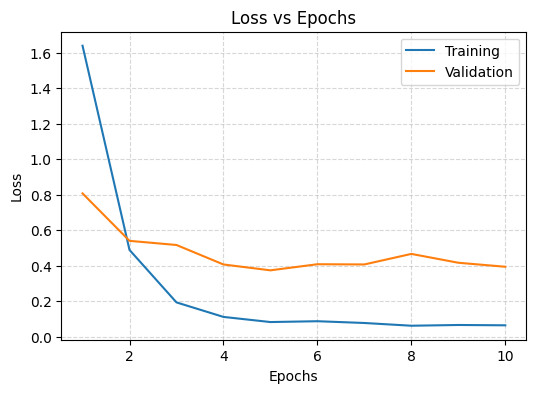

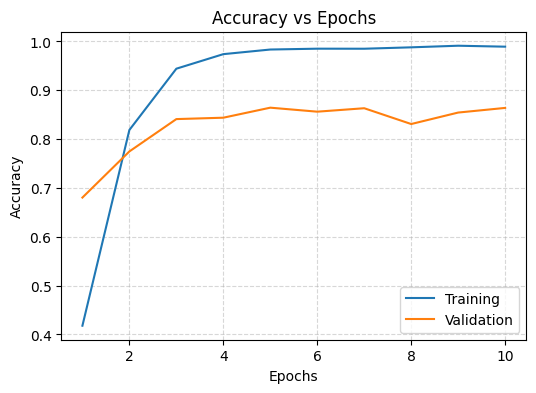

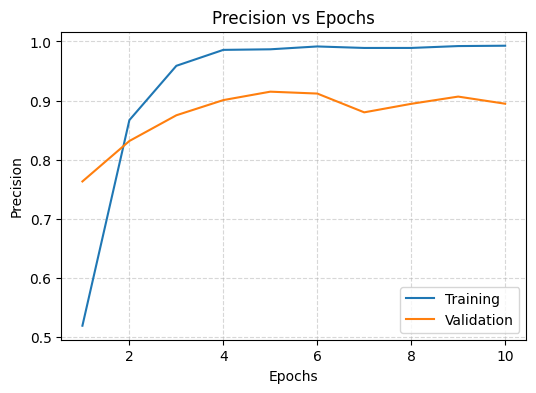

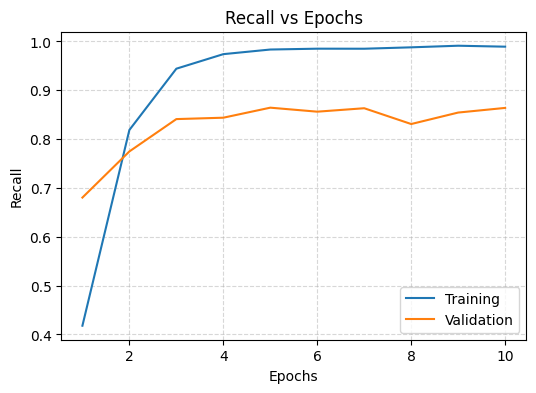

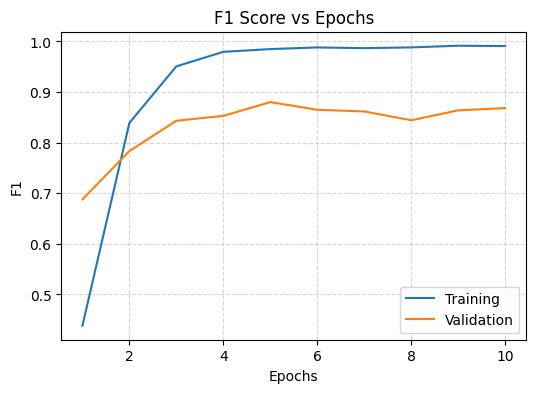

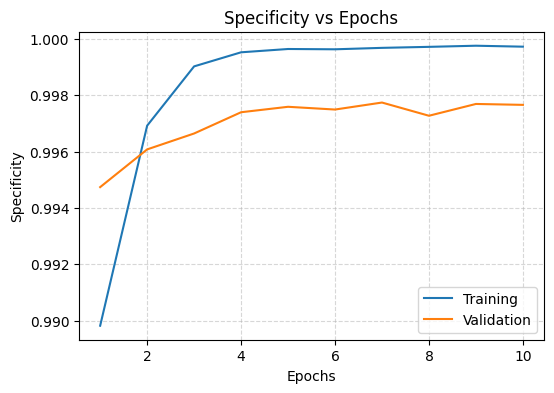

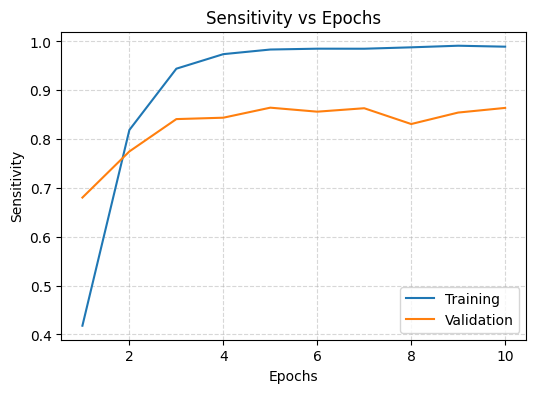

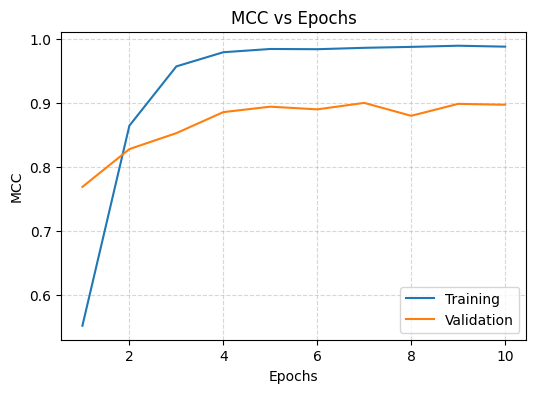

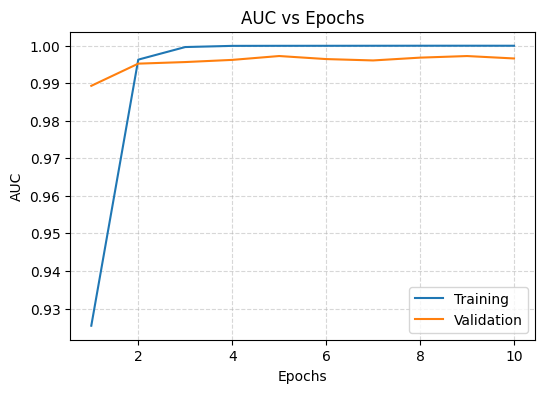

In [14]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")


In [15]:
if os.path.exists("best_mobilenetv2_44c.pth"):
    model.load_state_dict(torch.load("best_mobilenetv2_44c.pth"))

    print("Best model loaded.")
else:
    print("No saved model found.")


Best model loaded.


In [16]:
# Load best model
model.load_state_dict(torch.load("best_mobilenetv2_44c.pth"))

model.eval()


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequent

In [17]:
test_metrics = get_metrics()
test_loss = 0
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()

        preds = out.argmax(1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

        for m in test_metrics.values():
            m.update(out, y)

test_loss /= len(test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")

for k, v in test_metrics.items():
    print(f"{k.upper()}: {v.compute().item():.4f}")


Testing: 100%|██████████| 56/56 [00:05<00:00,  9.85it/s]


===== TEST RESULTS =====
Test Loss: 0.3621
ACC: 0.8328
PRECISION: 0.8835
RECALL: 0.8328
F1: 0.8481
AUC: 0.9976
MCC: 0.8852


In [18]:
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print("\n===== CLASSIFICATION REPORT =====\n")
print(classification_report(all_targets, all_preds, digits=4))



===== CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

           0     0.9706    0.9429    0.9565        35
           1     0.9200    1.0000    0.9583        46
           2     0.8378    0.9118    0.8732        34
           3     0.9231    0.9231    0.9231        13
           4     1.0000    1.0000    1.0000        22
           5     1.0000    0.9333    0.9655        15
           6     0.7500    0.6667    0.7059         9
           7     0.7778    0.7000    0.7368        10
           8     0.7500    0.5455    0.6316        11
           9     1.0000    1.0000    1.0000         4
          10     1.0000    0.6667    0.8000         3
          11     0.7500    0.6000    0.6667         5
          12     1.0000    1.0000    1.0000         5
          13     0.8889    1.0000    0.9412         8
          14     0.7500    0.4286    0.5455         7
          15     1.0000    0.7273    0.8421        11
          16     1.0000    0.9474    0.9730  

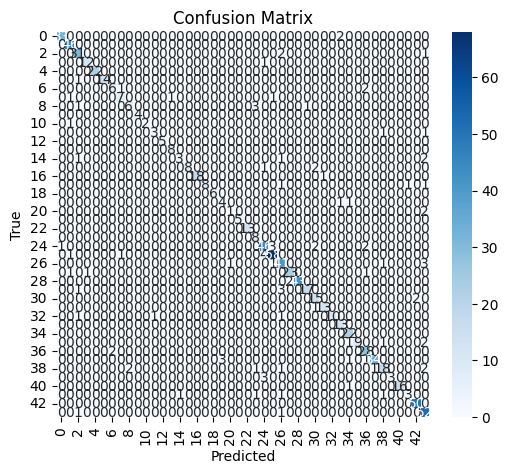

In [19]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [20]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


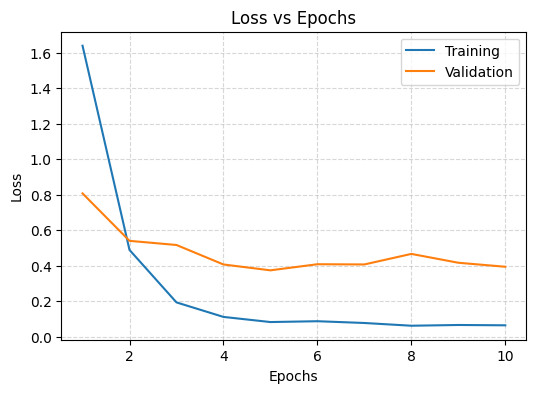

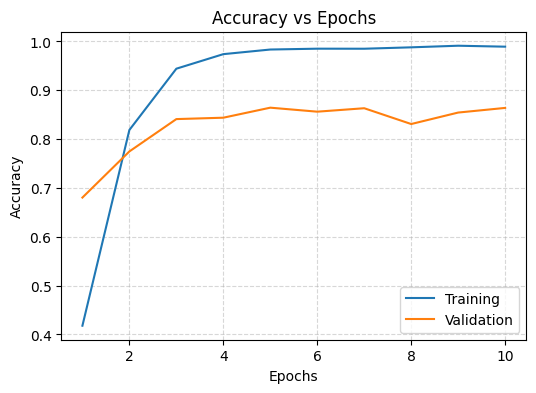

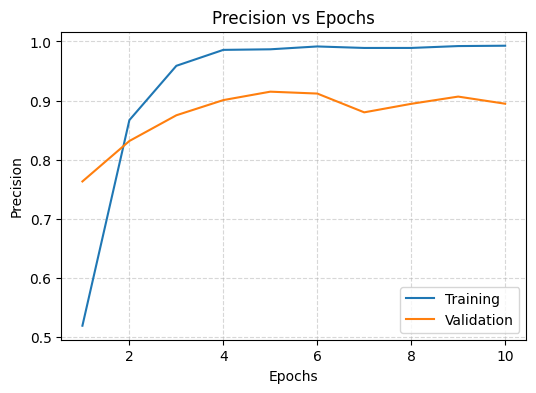

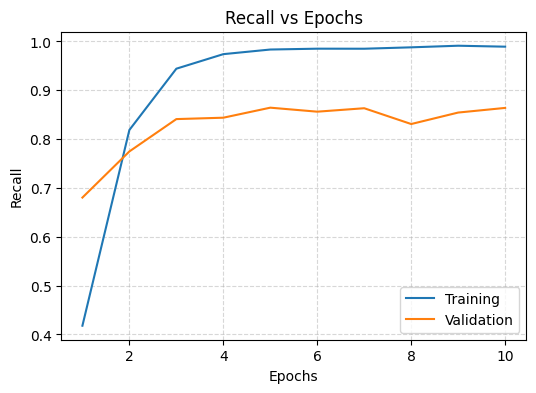

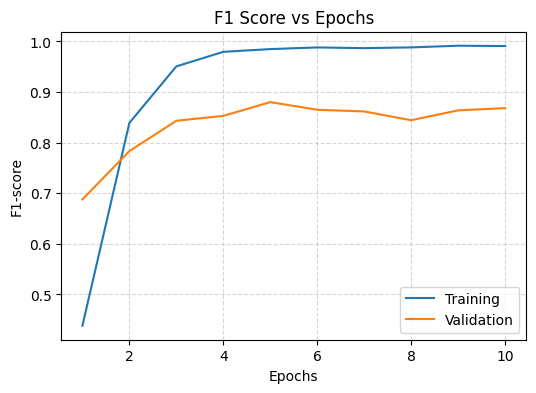

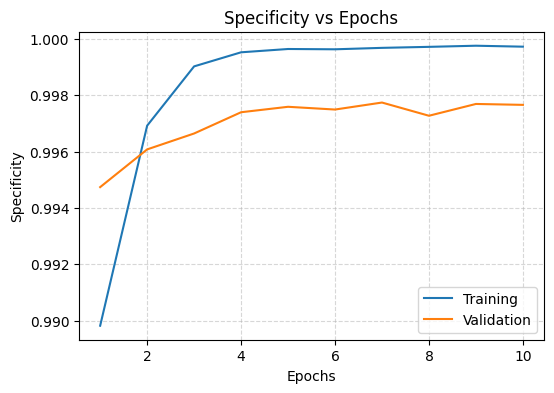

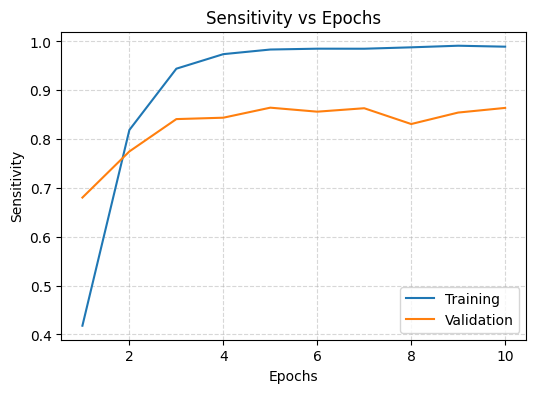

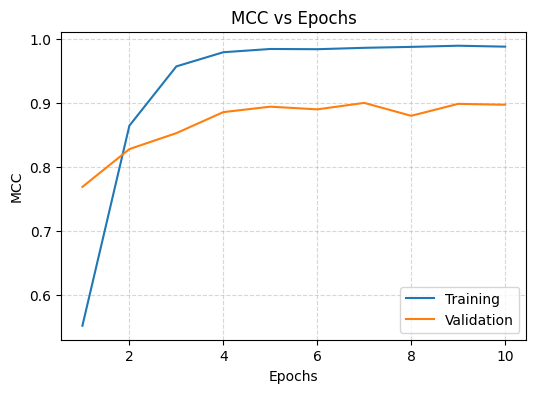

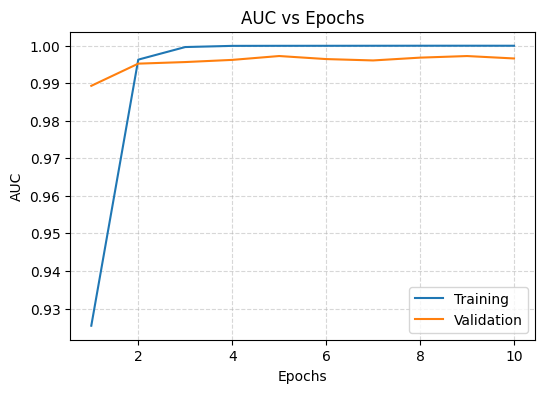

In [21]:
plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1-score")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")
